In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import nltk
import seaborn as sns

In [3]:
#-------------- Reading Dataset ----------------#
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
df = df.head(50000)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
print("Shape of Dataset :- ",df.shape)

Shape of Dataset :-  (50000, 10)


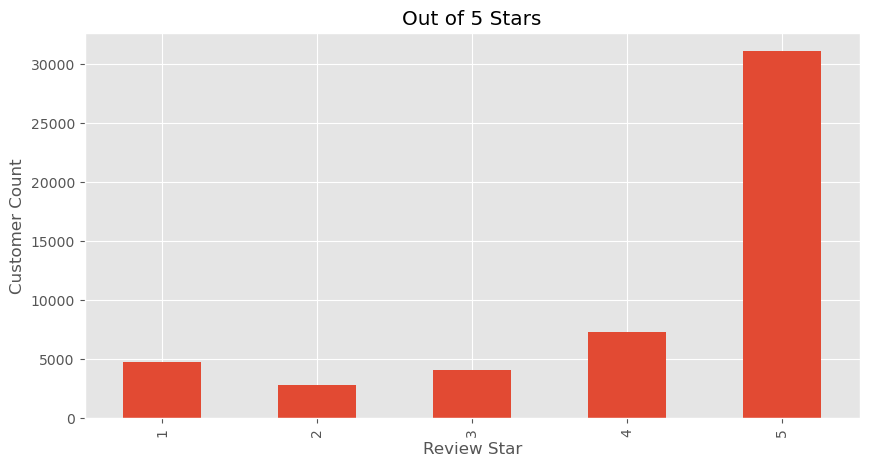

In [5]:
#------- Value Counts ---------#
ax = df['Score'].value_counts().sort_index().plot(kind='bar',title='Out of 5 Stars', figsize=(10,5))
ax.set_xlabel('Review Star')
ax.set_ylabel('Customer Count')
plt.show()

In [6]:
#----------- NLTK ------------------#
example = df['Text'][101]
print(example)

Arrived slightly thawed. My parents wouldn't accept it. However, the company was very helpful and issued a full refund.


In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Arrived',
 'slightly',
 'thawed',
 '.',
 'My',
 'parents',
 'would',
 "n't",
 'accept',
 'it']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Arrived', 'NNP'),
 ('slightly', 'RB'),
 ('thawed', 'VBD'),
 ('.', '.'),
 ('My', 'PRP$'),
 ('parents', 'NNS'),
 ('would', 'MD'),
 ("n't", 'RB'),
 ('accept', 'VB'),
 ('it', 'PRP')]

In [9]:
entites = nltk.chunk.ne_chunk(tagged)
entites.pprint()

(S
  (GPE Arrived/NNP)
  slightly/RB
  thawed/VBD
  ./.
  My/PRP$
  parents/NNS
  would/MD
  n't/RB
  accept/VB
  it/PRP
  ./.
  However/RB
  ,/,
  the/DT
  company/NN
  was/VBD
  very/RB
  helpful/JJ
  and/CC
  issued/VBD
  a/DT
  full/JJ
  refund/NN
  ./.)


# VADER

- Classifies text in 3 categories, i.e. positive, negative, and neutral.

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [11]:
sia.polarity_scores('I am so fucked up!!!')

{'neg': 0.65, 'neu': 0.35, 'pos': 0.0, 'compound': -0.7628}

In [12]:
sia.polarity_scores(example)

{'neg': 0.103, 'neu': 0.752, 'pos': 0.145, 'compound': 0.2285}

In [13]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(res).T
vaders.head()

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.079,0.853,0.068,-0.1027
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


In [15]:
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')

In [16]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot VADERS Results

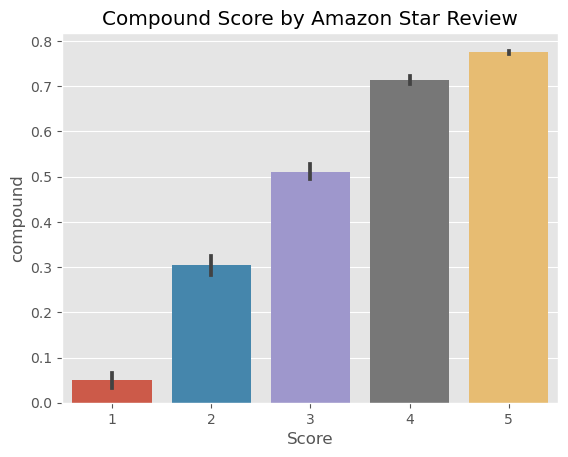

In [17]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title("Compound Score by Amazon Star Review")
plt.show()

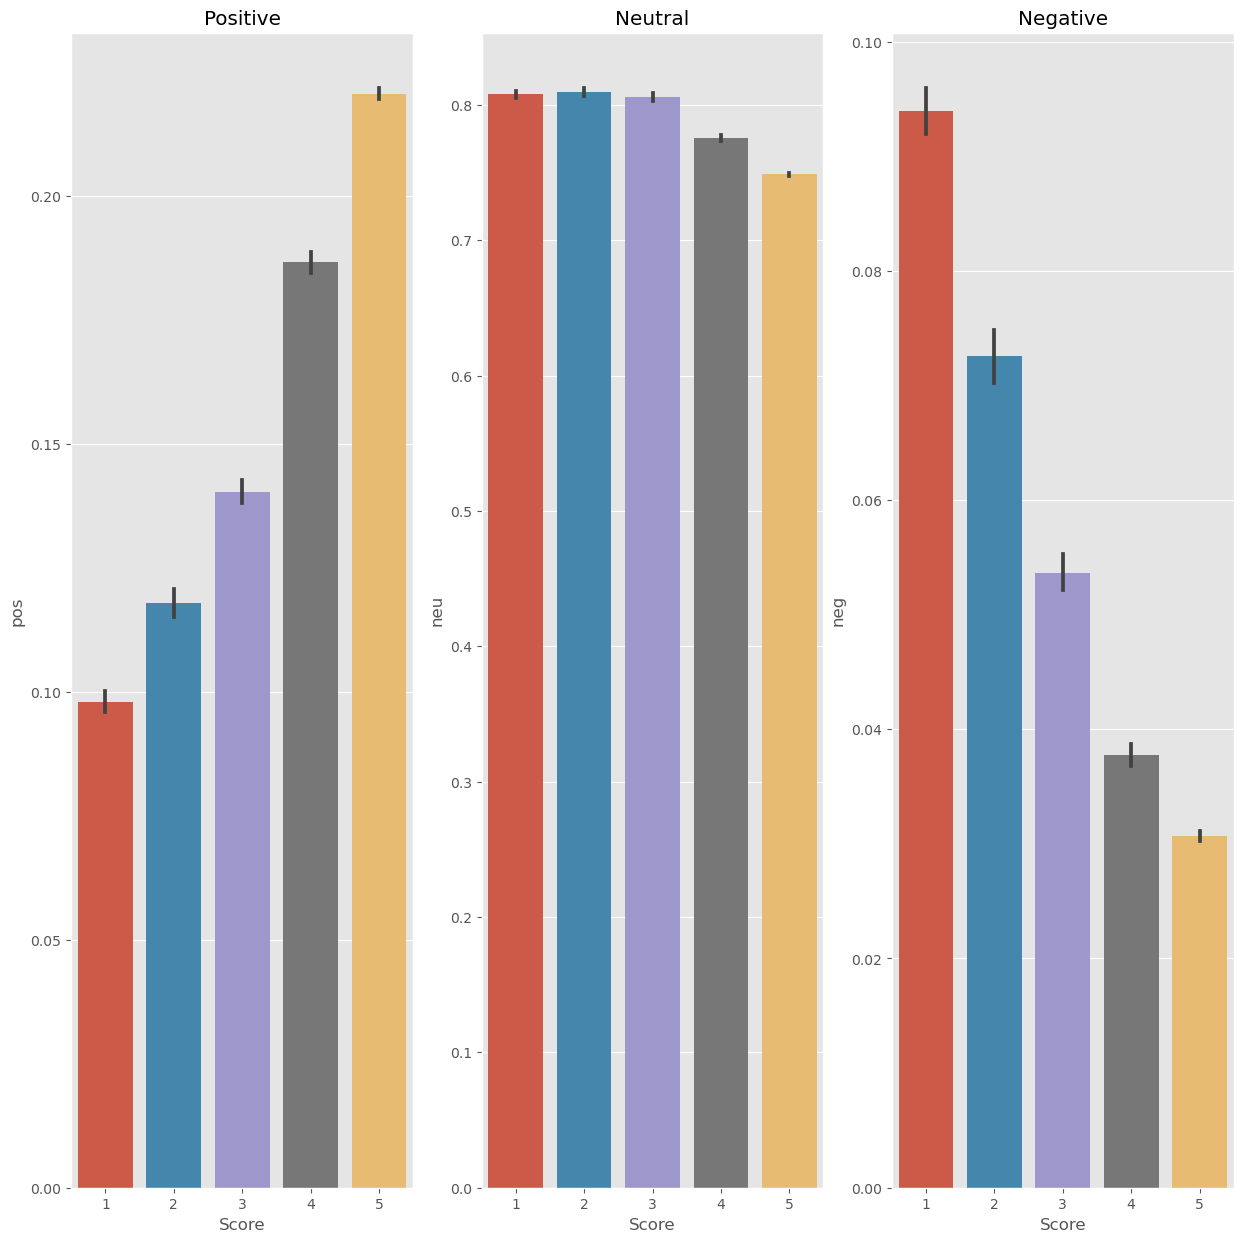

In [18]:
fig, axs = plt.subplots(1,3, figsize=(15,15))
sns.barplot(data=vaders, x='Score', y='pos',ax = axs[0])
sns.barplot(data=vaders, x='Score', y='neu',ax = axs[1])
sns.barplot(data=vaders, x='Score', y='neg',ax = axs[2])

axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.show()
        

# RoBERT Model

In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [20]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [21]:
#--------------- VADER Results ---------------#
print(example)
sia.polarity_scores(example)

Arrived slightly thawed. My parents wouldn't accept it. However, the company was very helpful and issued a full refund.


{'neg': 0.103, 'neu': 0.752, 'pos': 0.145, 'compound': 0.2285}

In [22]:
#------------- RoBERTa Results --------------#
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.062902555, 'roberta_neu': 0.29451612, 'roberta_pos': 0.64258134}


In [23]:
model = model.to('cuda')
def RoBERTa_polarity_scores(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    encoded_text = encoded_text.to('cuda')
    output = model(**encoded_text)
    scores = output[0][0].cpu().detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [24]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_results = sia.polarity_scores(text)
        vader_results_rename = {}
        for key, value in vader_results.items():
            vader_results_rename[f"vader_{key}"] = value
        roberta_results = RoBERTa_polarity_scores(text)
        both = {**vader_results_rename, **roberta_results}
        res[myid] = both
#         break
    except:
        print(f"Passing {myid}")
        pass

  0%|          | 0/50000 [00:00<?, ?it/s]

Passing 83
Passing 187
Passing 529
Passing 540
Passing 746
Passing 863
Passing 1053
Passing 1070
Passing 1156
Passing 1321
Passing 1375
Passing 1498
Passing 1575
Passing 1796
Passing 1826
Passing 2169
Passing 2248
Passing 2476
Passing 2492
Passing 2584
Passing 2610
Passing 2897
Passing 2898
Passing 2902
Passing 2928
Passing 2942
Passing 2944
Passing 2947
Passing 2948
Passing 3022
Passing 3023
Passing 3025
Passing 3306
Passing 3788
Passing 3969
Passing 4107
Passing 4110
Passing 4307
Passing 4316
Passing 4408
Passing 4483
Passing 4512
Passing 4553
Passing 4583
Passing 5040
Passing 5182
Passing 5192
Passing 5365
Passing 5442
Passing 5709
Passing 5998
Passing 6003
Passing 6007
Passing 6106
Passing 6234
Passing 6558
Passing 6651
Passing 6798
Passing 6838
Passing 6850
Passing 6886
Passing 6905
Passing 6955
Passing 7077
Passing 7088
Passing 7201
Passing 7604
Passing 7608
Passing 7671
Passing 7701
Passing 7810
Passing 7907
Passing 8077
Passing 8131
Passing 8266
Passing 8740
Passing 8757
Passin

In [30]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940396,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [31]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### Compare scores between VADER and RoBERTa

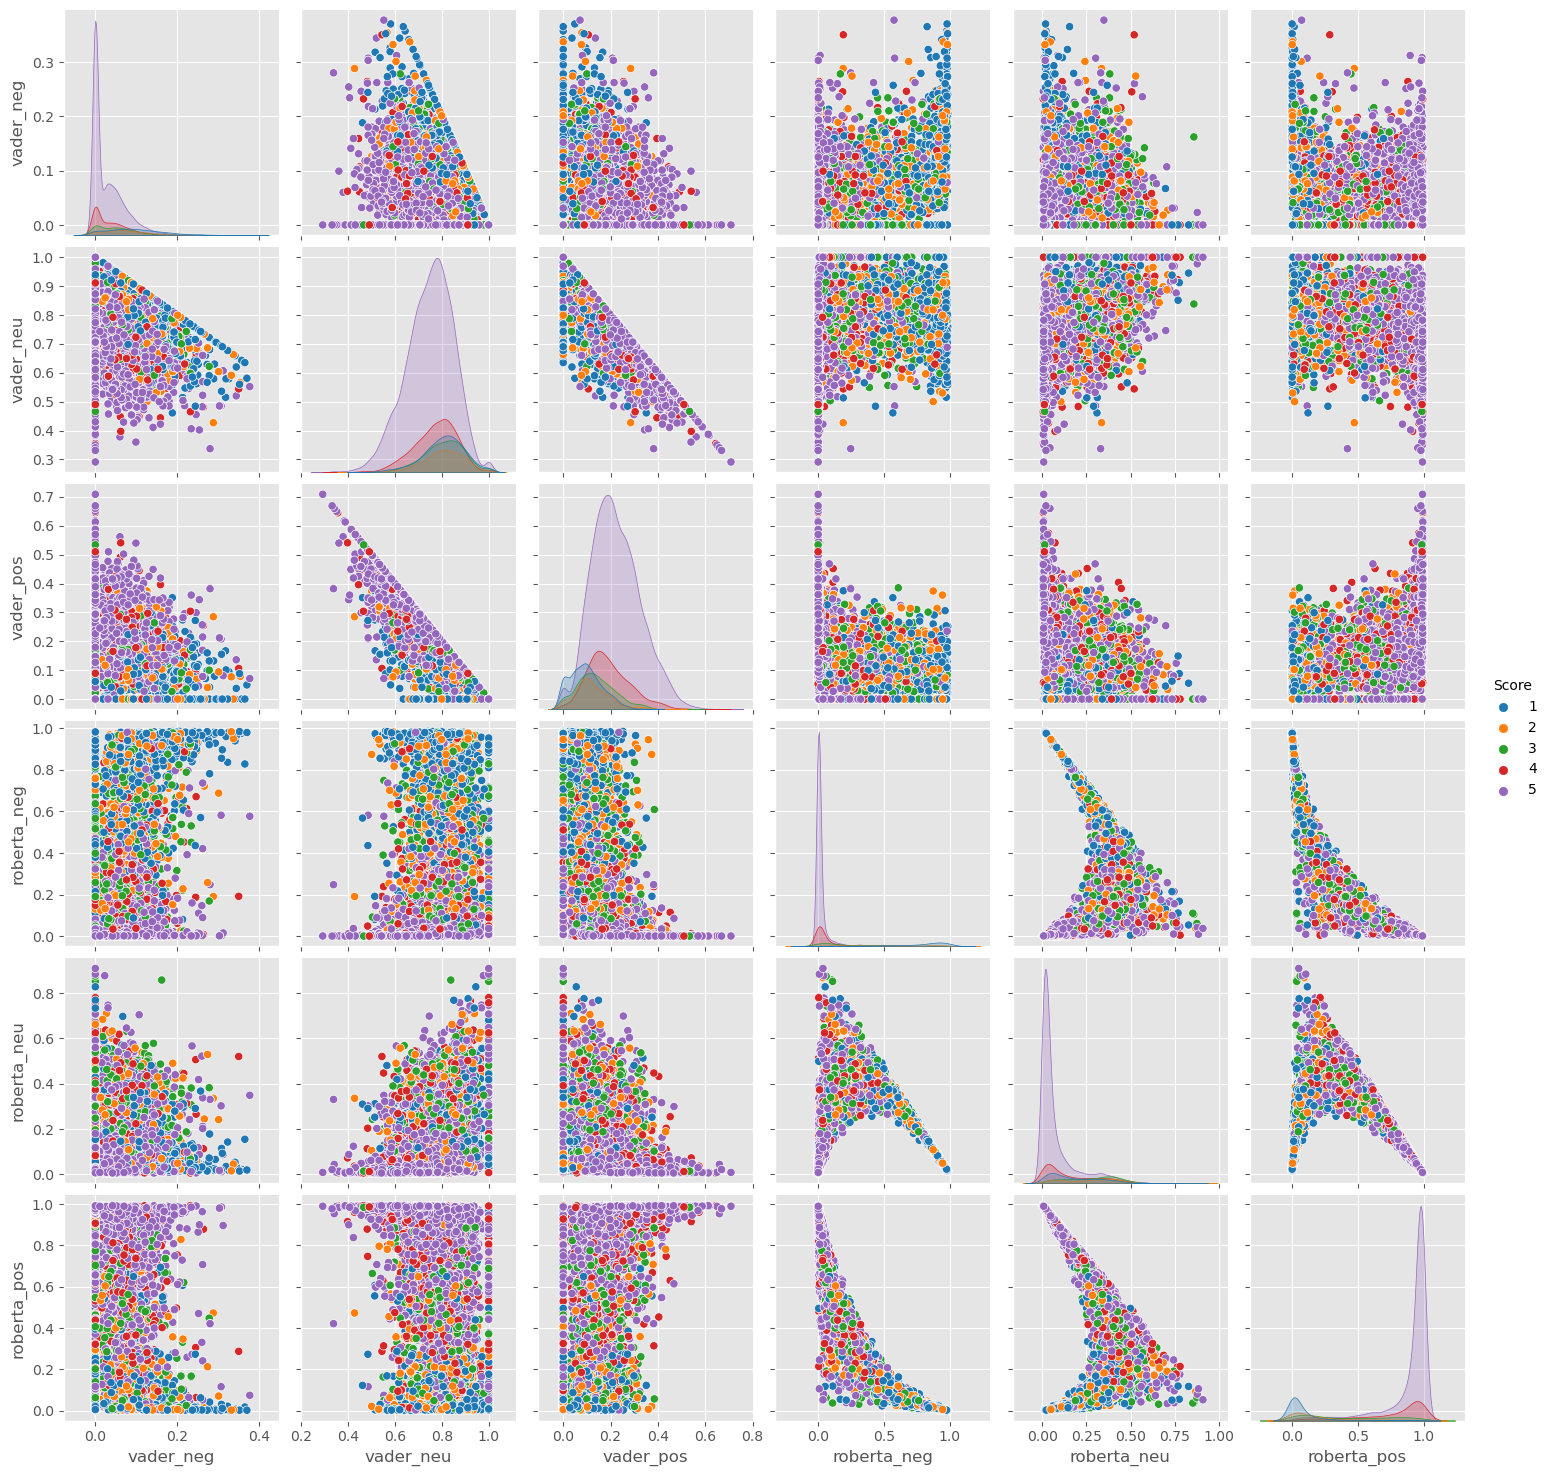

In [33]:
sns.pairplot(data=results_df,
            vars = ['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10'
            )
plt.show()

In [36]:
#--------------- Checking Scores for the most positively classified 1 star rating by RoBERTa ---------------------#
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

In [37]:
#--------------- Checking Scores for the most negatively classified 5 star rating by RoBERTa ---------------------#
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'THEY ARE DELICIOUS NOT SALTY YOU CAN SIT AND EAT 2-3 2 OUNCE BAGS AT A TIME I GIVE THESE 5 STARS PLUS I HAVE TO STOP MYSELF FROM EATING THEM THEY ARE DELICIOUS.'